In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
import ipynbname
from endaaman.ml import fix_global_seed

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)

DPI = 600

sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 
plt.rcParams['figure.dpi'] = DPI

os.makedirs('out/figs', exist_ok=True)

fix_global_seed()

# print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))

now working /home/ken/src/github.com/endaaman/bt


## fig1 pie
- Draw pie chart ing fig1

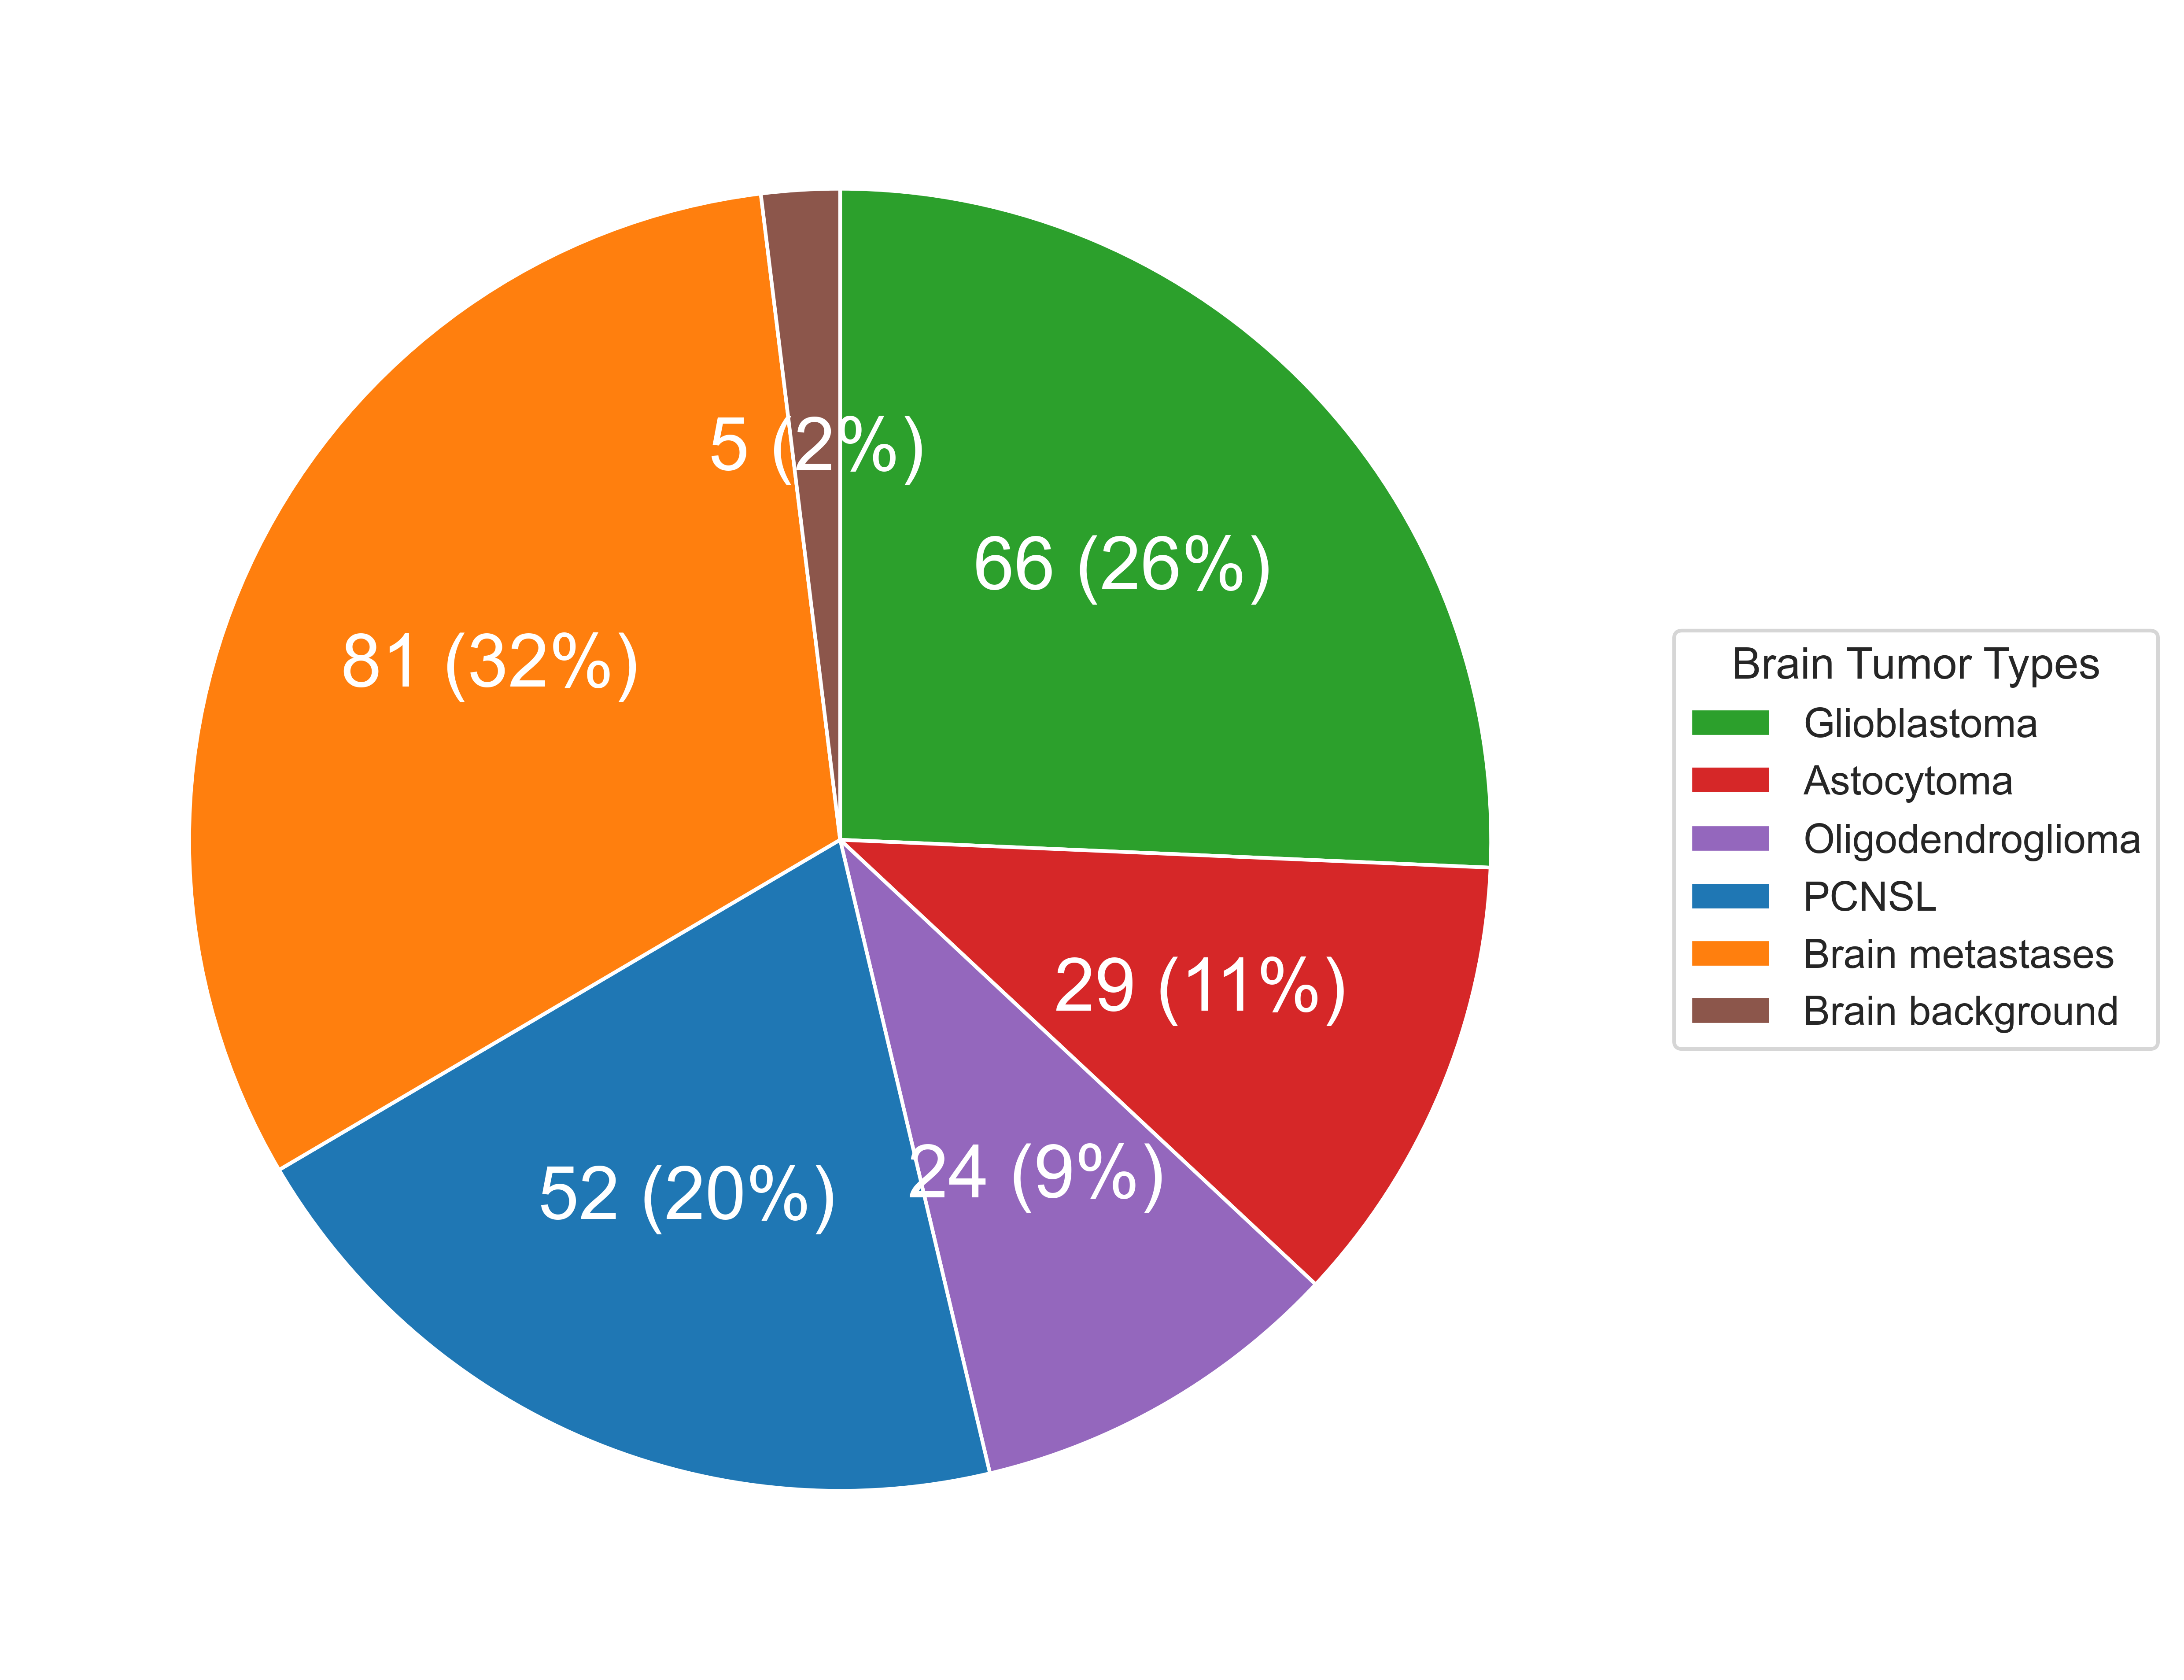

In [2]:
data = {
    'Glioblastoma': 66,
    'Astocytoma': 29,
    'Oligodendroglioma': 24,
    'PCNSL': 52,
    'Brain metastases': 81,
    'Brain background': 5,
}

colors = [
    sns.color_palette()[2],
    sns.color_palette()[3],
    sns.color_palette()[4],
    sns.color_palette()[0],
    sns.color_palette()[1],
    sns.color_palette()[5],
]



labels = list(data.keys())
counts = list(data.values())
total = sum(counts)

plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    counts, 
    labels=None,
    # labels=labels,
    autopct=lambda p: f'{round(p*total/100)} ({round(p)}%)',
    startangle=90, 
    counterclock=False, 
    colors=colors
)

for text in autotexts:
    text.set_fontsize(20)
    text.set_color('white')
plt.legend(wedges, labels, title="Brain Tumor Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig("out/figs/dataset_pie.png", format="png", dpi=300)
plt.show()

## fig2

In [3]:
from datasets import FoldDataset

ds = FoldDataset(
    source='enda4_512',
    fold=-1,
    total_fold=5,
    code='LMGAO_',
    limit=-1,
    upsample=False,
    target='all',
)
# ds.df

Using cache files
loaded all for fold -1
Balance: cases
0 all:51 A:6 G:13 L:11 M:16 O:5
1 all:49 A:5 G:13 L:10 M:17 O:4
2 all:49 A:5 G:13 L:10 M:16 O:5
3 all:50 A:5 G:14 L:10 M:16 O:5
4 all:50 A:5 G:13 L:11 M:16 O:5
Balance: tiles
0 all:28630 A:2937 G:9142 L:4060 M:9375 O:3116
1 all:26404 A:2016 G:9627 L:2891 M:9711 O:2159
2 all:26055 A:2158 G:9942 L:3068 M:8412 O:2475
3 all:27244 A:2217 G:10332 L:3312 M:8806 O:2577
4 all:27053 A:2512 G:8900 L:3657 M:9066 O:2918


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec


# sns.set_theme(style="ticks")
# sns.reset_defaults()

legend_full_names = {
    'G': 'Glioblastoma',
    'A': 'Astrocytoma',
    'O': 'Oligodendroglioma',
    'L': 'PCNSL',
    'M': 'Brain Metastases',
}

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# データの最大値を取得
max_value = ds.df['diag'].value_counts().max()

# 上部のプロット（600以上）
sns.countplot(data=ds.df, x='name', hue='diag', order=ds.df['name'].value_counts().index, ax=ax1, width=1.0)
ax1.set_ylim(600, 2000)
ax1.set_xticks([])
ax1.set_xlabel('')

# 下部のプロット（0から600）
sns.countplot(data=ds.df, x='name', hue='diag', order=ds.df['name'].value_counts().index, ax=ax2, width=1.0)
ax2.set_ylim(0, 600)
ax2.set_xticks([])
ax2.set_xlabel('Cases')
ax2.set_yticks([0, 100, 200, 300, 400, 500, 600])

# y軸のラベルを設定
ax2.set_ylabel('Patch Count per Case')
ax1.set_ylabel('')

# 横線を追加（下部プロットのみ）
for y in [500, 100, 50, 25, 10]:
    ax2.axhline(y=y, color='gray', linestyle='--', alpha=0.8, linewidth=1)
    if y not in [500, 100]:
        ax2.text(-0.01, y, str(y), va='center', ha='right', transform=ax2.get_yaxis_transform())

# legendを手動で並べ替えてfull nameで表示（下部プロットにのみ配置）
handles, labels = ax2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax2.legend(
    [by_label[l] for l in legend_full_names],
    list(legend_full_names.values()),
    title='Diagnosis',
    loc='upper right'
)
ax1.legend().remove()  # 上部プロットのlegendを削除

# プロット間の空白を調整
plt.tight_layout()
fig.subplots_adjust(hspace=0.07)

# 軸の分割を示す斜線を追加
d = .015  # サイズ
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# def draw_wave(ax, x, y, width, height, wavelength=0.1, amplitude=0.01):
#     t = np.linspace(0, width, 100)
#     ax.plot(x + t, y + amplitude * np.sin(2 * np.pi * t / wavelength), 
#             color='k', clip_on=False, transform=ax.transAxes)
# draw_wave(ax1, 0, -0.02, 1, 0.02)
# draw_wave(ax2, 0, 1.02, 1, 0.02)

plt.savefig("out/figs/dataset_count_per_class.png", format="png", dpi=300)
plt.show()